In [265]:
import pandas as pd
import numpy as np
import regex as re
from functools import reduce
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.graphics.tsaplots as stats

Turistes estrangers amb destinació principal a Catalunya. Per motiu del viatge, país de residència, durada del viatge, tipus d'allotjament, forma d'organització, via d'accés i mes

In [266]:
#Importing dfs with trends data
df1 = pd.read_csv("../forecasting-tourism-trends/barcelona.csv")
df2 = pd.read_csv("../forecasting-tourism-trends/city_trip_barcelona.csv")
df3 = pd.read_csv("../forecasting-tourism-trends/flight_barcelona.csv")
df4 = pd.read_csv("../forecasting-tourism-trends/holiday_barcelona.csv")
df5 = pd.read_csv("../forecasting-tourism-trends/hotel_barcelona.csv")
df6 = pd.read_csv("../forecasting-tourism-trends/tourist_info_barcelona.csv")
df7 = pd.read_csv("../forecasting-tourism-trends/train_barcelona.csv")
df8 = pd.read_csv("../forecasting-tourism-trends/visit_barcelona.csv")

# Mergind the different df into df_trends
dfs = [df1, df2, df3, df4, df5, df6, df7, df8]
df_trends = reduce(lambda left,right: pd.merge(left,right,on='Mes'), dfs)

df_trends.columns = ["period", "barcelona", "city_trip_barcelona", "flight_barcelona", 
                     "holiday_barcelona", "hotel_barcelona", "tourist_info_barcelona", 
                     "train_barcelona", "visit_barcelona"]

#Chaging period type to datetime format
df_trends["period"] = pd.to_datetime(df_trends["period"], format="%Y-%m")
df_trends = df_trends.sort_values(by="period", ascending=False).reset_index(drop=True)

#Delete the first observation of the df_trends as it does not appear in the hotel data
df_trends = df_trends.iloc[1:].copy()
df_trends.head(3)

,period,barcelona,city_trip_barcelona,flight_barcelona,holiday_barcelona,hotel_barcelona,tourist_info_barcelona,train_barcelona,visit_barcelona
1,2020-11-01,36,6,10,10,13,0,7,7
2,2020-10-01,58,0,11,12,16,0,7,9
3,2020-09-01,50,0,15,10,15,0,20,17


#### Inspecting the dataset

In [267]:
#Importing hotel visitors dataset
df = pd.read_csv("../forecasting-tourism-trends/2074c.csv")

#Deleting unnamed column
df = df.drop(columns="Unnamed: 2")

#Renaming column names
df.columns = ["period", "total"]

#Changing the period format
df["period"] = df["period"].str.replace(r"M", "-")
df["period"] = pd.to_datetime(df["period"], format="%Y-%m")

In [268]:
#Merging the two dataframes
df = df.merge(df_trends, on="period")

#Changing the total column type
df["total"] = df["total"].str.replace(r".", "")
df["total"] = pd.to_numeric(df["total"])

# There are two null values both in 2020 (march and may), so can be imputed by interpolating
df = df.interpolate(limit=2, limit_direction="forward")

# Set index to period
df = df.set_index("period")

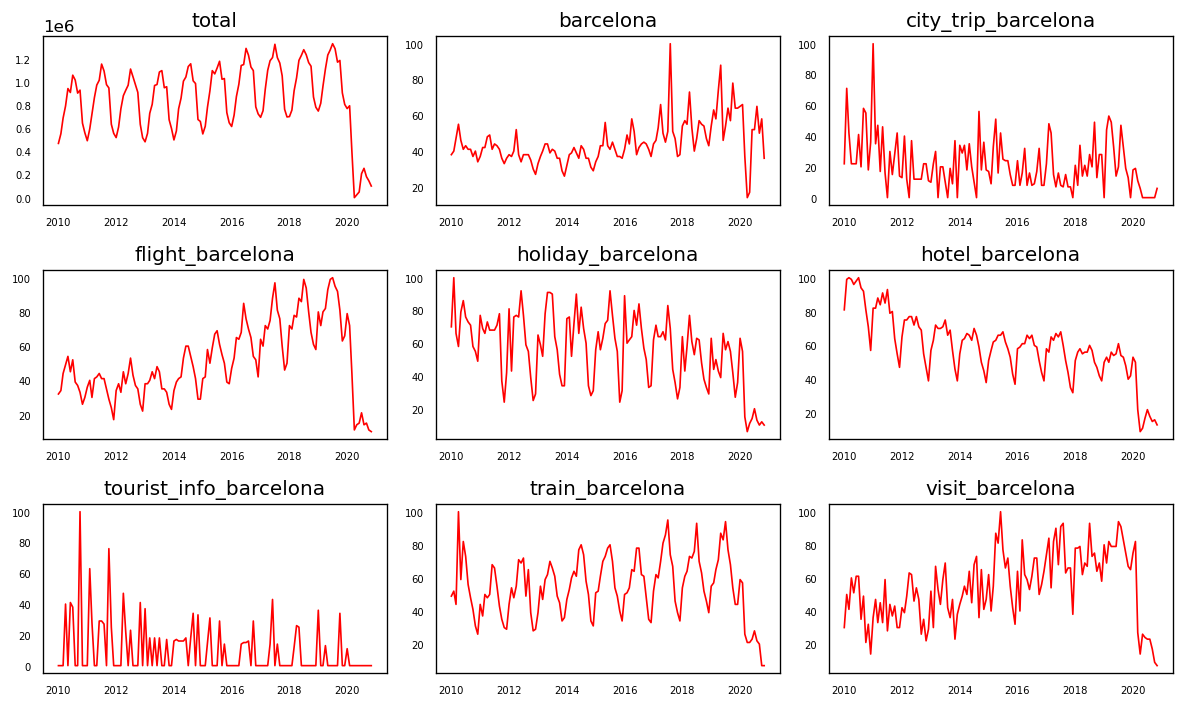

In [269]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
 data = df[df.columns[i]]
 ax.plot(data, color="red", linewidth=1)
 ax.set_title(df.columns[i])
 ax.xaxis.set_ticks_position("none")
 ax.yaxis.set_ticks_position("none")
 ax.tick_params(labelsize=6)
plt.tight_layout()

In [270]:
stat,p = stats.normaltest(df.total)
print("Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

AttributeError: module 'statsmodels.graphics.tsaplots' has no attribute 'normaltest'

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.heatmap(df.corr(), annot=True)

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['total'].hist(bins=40)
plt.title('Gold')
plt.subplot(1,2,2)
stats.probplot(df['total'], plot=plt);
df.total.describe().T

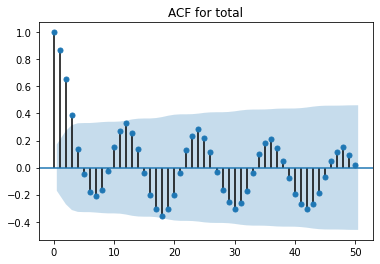

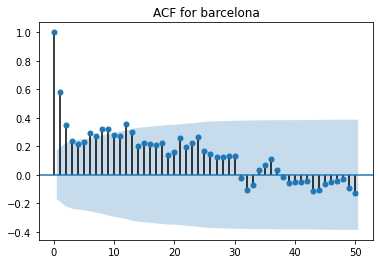

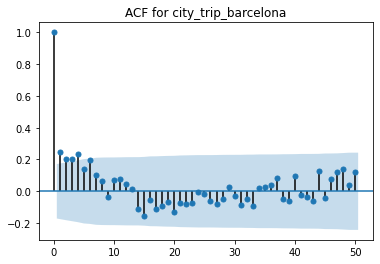

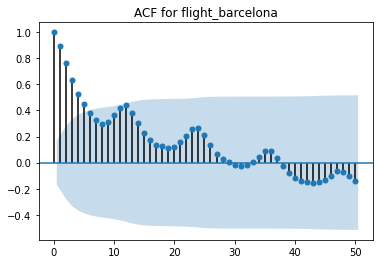

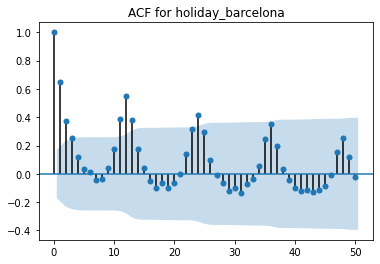

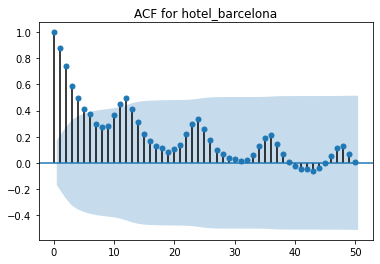

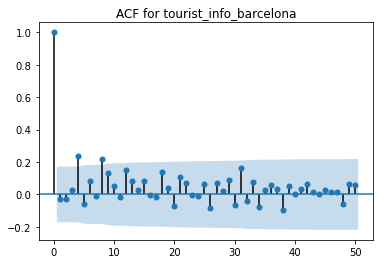

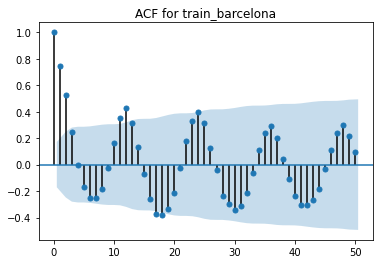

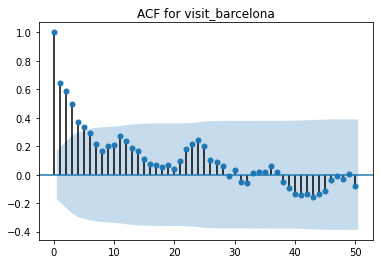

In [271]:
for i in df:
    stats.plot_acf(df[i], lags = 50)
    plt.title('ACF for %s' % i)
    plt.show()

In [261]:
#Train test split
X = df.drop("total", axis=1)
y = df["total"]

X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]

In [272]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    for mf in np.linspace(100, 150, 6):
        for ne in np.linspace(50, 100, 6):
            for md in np.linspace(20, 40, 5):
                for msl in np.linspace(30, 100, 8):
                    rfr = RandomForestRegressor(
                        max_features=int(mf),
                        n_estimators=int(ne),
                        max_depth=int(md),
                        min_samples_leaf=int(msl))
                    rfr.fit(X_tr, y_tr)
                    score.append([i,
                                  mf, 
                                  ne,
                                  md, 
                                  msl, 
                                  rfr.score(X_val, y_val)])
    i += 1

KeyError: "None of [Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')] are in the [columns]"